In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error


In [2]:
n_future = 20

# Convert series to supervised learning
def series_to_supervised(data, n_in=5, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [3]:
# Load dataset
dataset = pd.read_csv('technical_indicators/BHP/Trend/BHPTrend.csv', header=0, index_col=0)
## df1=dataset.iloc[:,[1,2,3,4,5,6]]
values = dataset.values
values = values.astype('float32')

# Normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# Reframe as supervised learning
reframed = series_to_supervised(scaled, 7, 2)
print(reframed.head())
print(reframed.shape)

# For n_in=14, n_future=20
print(reframed.head())
print(reframed.shape)


    var1(t-7)  var2(t-7)  var3(t-7)  var4(t-7)  var5(t-7)  var6(t-7)  \
7    0.473464   0.399862   0.572502   0.505595   0.000000   0.270387   
8    0.480391   0.473464   0.399862   0.572502   0.136755   0.319360   
9    0.495793   0.480391   0.473464   0.399862   0.231230   0.370372   
10   0.591920   0.495793   0.480391   0.473464   0.112204   0.480676   
11   0.504141   0.591920   0.495793   0.480391   0.091429   0.333697   

    var7(t-7)  var8(t-7)  var9(t-7)  var10(t-7)  ...  var20(t+1)  var21(t+1)  \
7    0.251201   0.260576   0.349954    0.000000  ...    0.030320    0.292107   
8    0.301592   0.224096   0.307113    0.000000  ...    0.029384    0.336335   
9    0.339905   0.276756   0.277163    0.136755  ...    0.029384    0.353590   
10   0.429497   0.365488   0.375592    0.231230  ...    0.028448    0.261199   
11   0.430604   0.380006   0.392274    0.112204  ...    0.025753    0.287804   

    var22(t+1)  var23(t+1)  var24(t+1)  var25(t+1)  var26(t+1)  var27(t+1)  \
7     0.

In [5]:
# Split into train and test sets
values = reframed.values
train = values[:1079, :]
test = values[1080:, :]

# Split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# Reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
# We reshaped the input into the 3D format as expected by MLP, namely [samples, timesteps, features].

(1079, 1, 260) (1079,) (4167, 1, 260) (4167,)


In [13]:
import torch
import torch.nn as nn
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define MLP Model for Classification
class MLP_Classifier(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size, num_classes=2):
        super(MLP_Classifier, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_sizes[0])
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_sizes[0], hidden_sizes[1])
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_sizes[1], hidden_sizes[2])
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(hidden_sizes[2], output_size)

        # Activation for classification
        if num_classes == 2:  # Binary classification
            self.activation = nn.Sigmoid()
        else:  # Multi-class classification
            self.activation = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        x = self.relu3(self.fc3(x))
        x = self.fc4(x)
        x = self.activation(x)  # Apply activation at the end
        return x

# Example: Change `num_classes` based on your task
num_classes = 2  # Set this to the actual number of classes in your dataset
output_size = 1 if num_classes == 2 else num_classes  # 1 for binary, num_classes for multi-class

# Initialize MLP Classification Model
hidden_layers = [64, 32, 16]
model = MLP_Classifier(input_size=train_X.shape[2], hidden_sizes=hidden_layers, output_size=output_size, num_classes=num_classes).to(device)

# Define Loss Function and Optimizer
criterion = nn.BCELoss()

optimizer = optim.Adam(model.parameters(), lr=0.001)

# Print model summary
print(model)


MLP_Classifier(
  (fc1): Linear(in_features=260, out_features=64, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=32, out_features=16, bias=True)
  (relu3): ReLU()
  (fc4): Linear(in_features=16, out_features=1, bias=True)
  (activation): Sigmoid()
)


Epoch [50/500], Train Loss: 0.6277, Val Loss: 0.6665
Epoch [100/500], Train Loss: 0.2973, Val Loss: 0.7517
Epoch [150/500], Train Loss: 0.1722, Val Loss: 0.5833
Epoch [200/500], Train Loss: 0.1365, Val Loss: 0.7033
Epoch [250/500], Train Loss: 0.1147, Val Loss: 0.8974
Epoch [300/500], Train Loss: 0.1023, Val Loss: 1.0036
Epoch [350/500], Train Loss: 0.0947, Val Loss: 1.1657
Epoch [400/500], Train Loss: 0.0885, Val Loss: 1.0856
Epoch [450/500], Train Loss: 0.0928, Val Loss: 0.9169
Epoch [500/500], Train Loss: 0.0800, Val Loss: 1.1798


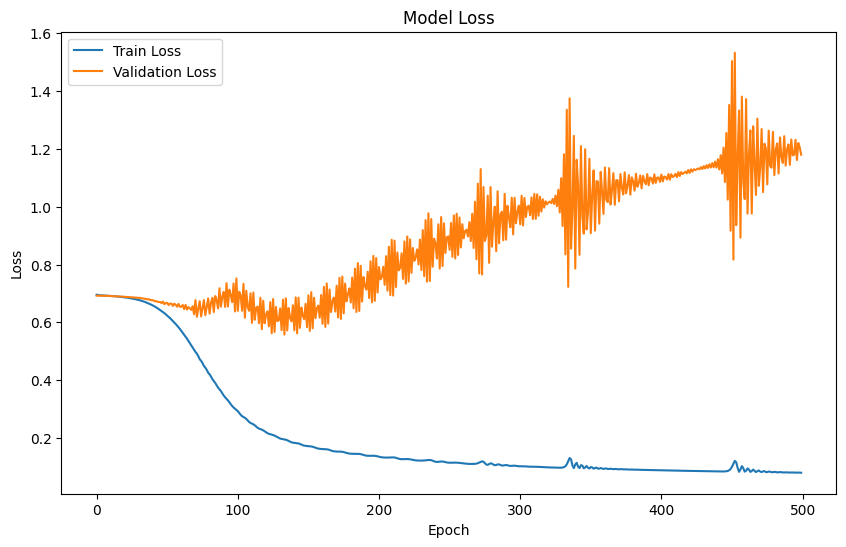

In [14]:
train_X_tensor = torch.tensor(train_X, dtype=torch.float32).to(device)
train_y_tensor = torch.tensor(train_y, dtype=torch.float32).unsqueeze(1).to(device)  # Ensure shape is (batch_size, 1)
test_X_tensor = torch.tensor(test_X, dtype=torch.float32).to(device)
test_y_tensor = torch.tensor(test_y, dtype=torch.float32).unsqueeze(1).to(device)

# Training parameters
epochs = 500
batch_size = 80
train_losses = []
val_losses = []

# Training Loop
for epoch in range(epochs):
    model.train()  # Set model to training mode
    optimizer.zero_grad()

    # Forward pass
    outputs = model(train_X_tensor)
    outputs = outputs.squeeze(1)  # Remove the extra dimension
    # print((outputs.shape), (train_y_tensor.shape))
    
    loss = criterion(outputs, train_y_tensor)

    # Backward pass
    loss.backward()
    optimizer.step()

    # Validation
    model.eval()
    with torch.no_grad():
        val_outputs = model(test_X_tensor)
        val_outputs = val_outputs.squeeze(1)  # Remove the extra dimension
        val_loss = criterion(val_outputs, test_y_tensor)

    # Store loss values
    train_losses.append(loss.item())
    val_losses.append(val_loss.item())

    # Print progress every 50 epochs
    if (epoch + 1) % 50 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}")

# Plot Training & Validation Loss
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title("Model Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.show()


In [51]:
class MLP_Classifier(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size, num_classes=2, dropout_rate=0.3):
        super(MLP_Classifier, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_sizes[0])
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout_rate)  # Dropout

        self.fc2 = nn.Linear(hidden_sizes[0], hidden_sizes[1])
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout_rate)

        self.fc3 = nn.Linear(hidden_sizes[1], hidden_sizes[2])
        self.relu3 = nn.ReLU()
        self.dropout3 = nn.Dropout(dropout_rate)

        self.fc4 = nn.Linear(hidden_sizes[2], output_size)

        # Activation for classification
        if num_classes == 2:  
            self.activation = nn.Sigmoid()
        else:  
            self.activation = nn.Softmax(dim=1)

    def forward(self, x):
        # x = x.view(x.shape[0], -1)
        x = self.relu1(self.fc1(x))
        x = self.dropout1(x)

        x = self.relu2(self.fc2(x))
        x = self.dropout2(x)

        x = self.relu3(self.fc3(x))
        x = self.dropout3(x)

        x = self.fc4(x)
        x = self.activation(x)
        return x
    

hidden_layers = [64, 32, 16]
num_classes = 2
output_size = 1 if num_classes == 2 else num_classes
dropout_rate = 0.3 

model = MLP_Classifier(input_size=train_X.shape[2], hidden_sizes=hidden_layers, output_size=output_size, num_classes=num_classes, dropout_rate=dropout_rate).to(device)

criterion = nn.BCELoss()

optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-3)  # L2 Regularization (Weight Decay)

print(model)

MLP_Classifier(
  (fc1): Linear(in_features=260, out_features=64, bias=True)
  (relu1): ReLU()
  (dropout1): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (relu2): ReLU()
  (dropout2): Dropout(p=0.3, inplace=False)
  (fc3): Linear(in_features=32, out_features=16, bias=True)
  (relu3): ReLU()
  (dropout3): Dropout(p=0.3, inplace=False)
  (fc4): Linear(in_features=16, out_features=1, bias=True)
  (activation): Sigmoid()
)


In [38]:
print(train_X_tensor.shape)

torch.Size([1079, 1, 260])


Early stopping at epoch 467


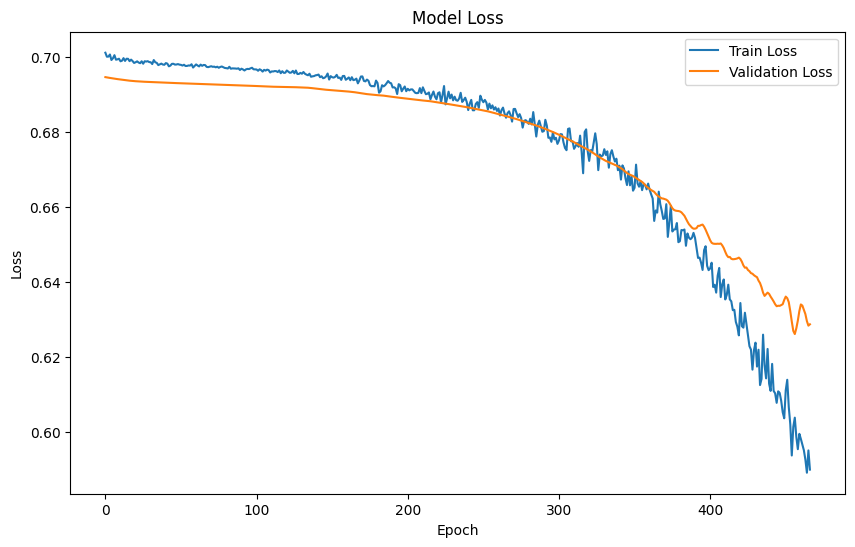

In [52]:
train_X_tensor = torch.tensor(train_X, dtype=torch.float32).to(device)
train_y_tensor = torch.tensor(train_y, dtype=torch.float32).unsqueeze(1).to(device)  # Ensure shape is (batch_size, 1)
test_X_tensor = torch.tensor(test_X, dtype=torch.float32).to(device)
test_y_tensor = torch.tensor(test_y, dtype=torch.float32).unsqueeze(1).to(device)

epochs = 800
batch_size = 60
train_losses = []
val_losses = []

best_val_loss = float('inf')
patience, patience_limit = 0, 10  # Stop if no improvement in 10 epochs

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    
    # Forward pass
    outputs = model(train_X_tensor)
    outputs = outputs.squeeze(1)
    loss = criterion(outputs, train_y_tensor)

    # Backward pass
    loss.backward()
    optimizer.step()

    # Validation
    model.eval()
    with torch.no_grad():
        val_outputs = model(test_X_tensor)
        val_outputs = val_outputs.squeeze(1)
        val_loss = criterion(val_outputs, test_y_tensor)

    # Store loss values
    train_losses.append(loss.item())
    val_losses.append(val_loss.item())

    # Early Stopping Condition
    if val_loss.item() < best_val_loss:
        best_val_loss = val_loss.item()
        patience = 0  # Reset patience if validation loss improves
    else:
        patience += 1  # Increase patience if no improvement
        if patience >= patience_limit:
            print(f"Early stopping at epoch {epoch+1}")
            break

# Plot Training & Validation Loss
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title("Model Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.show()


In [57]:
model.eval()

# Convert test data to PyTorch tensor and move to device
test_X_tensor = torch.tensor(test_X, dtype=torch.float32).to(device)

# Generate Predictions
with torch.no_grad():
    yhat_probs = model(test_X_tensor)  # Probability predictions

# Convert probabilities to NumPy
yhat_probs = yhat_probs.cpu().numpy()

# Convert probabilities to class labels (0 or 1)
yhat_classes = (yhat_probs > 0.5).astype(int)
yhat_classes = yhat_classes.squeeze(1)

# Print predictions
print("Predicted Probabilities:\n", yhat_probs[:10])  # Show first 10 predictions
print("Predicted Classes:\n", yhat_classes[:10])  # Show first 10 class labels



Predicted Probabilities:
 [[[0.36759713]]

 [[0.6231603 ]]

 [[0.46171165]]

 [[0.5625046 ]]

 [[0.57657593]]

 [[0.5325981 ]]

 [[0.43773913]]

 [[0.5584177 ]]

 [[0.6360652 ]]

 [[0.50215006]]]
Predicted Classes:
 [[0]
 [1]
 [0]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]]


In [58]:
print(test_y)
print(yhat_classes)

[0. 1. 0. ... 0. 1. 1.]
[[0]
 [1]
 [0]
 ...
 [1]
 [1]
 [1]]


In [60]:
# Evaluate the model
from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

# Accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(test_y, yhat_classes)
print('Accuracy: %f' % accuracy)
# Precision tp / (tp + fp)
precision = precision_score(test_y, yhat_classes)
print('Precision: %f' % precision)
# Recall: tp / (tp + fn)
recall = recall_score(test_y, yhat_classes)
print('Recall: %f' % recall)
# F1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(test_y, yhat_classes)
print('F1 score: %f' % f1)
# Kappa
kappa = cohen_kappa_score(test_y, yhat_classes)
print('Cohens kappa: %f' % kappa)
# ROC AUC
yhat_probs = yhat_probs.squeeze(1)
auc = roc_auc_score(test_y, yhat_probs)
print('ROC AUC: %f' % auc)
# Confusion matrix
matrix = confusion_matrix(test_y, yhat_classes)
print(matrix)

Accuracy: 0.614831
Precision: 0.575684
Recall: 0.988935
F1 score: 0.727735
Cohens kappa: 0.203907
ROC AUC: 0.821410
[[ 417 1581]
 [  24 2145]]


In [66]:
# Generate future predictions
n_future = 20
a = values[-n_future:,:-1]
a = a.reshape(a.shape[0], 1, -1)
print(a.shape)
a_tensor = torch.tensor(a, dtype=torch.float32).to(device)

with torch.no_grad():
    forecast = model(a_tensor)

forecast = forecast.cpu().numpy()
forecast = np.asarray(forecast)

forecast_classes = (forecast > 0.5).astype(int)
forecast_classes = forecast_classes.squeeze(1)
a = a.reshape((a.shape[0], a.shape[2]))
print(forecast_classes.shape, a.shape)
inv_forecast = np.concatenate((forecast_classes, a[:, -28:]), axis=1)  # Adjust based on your feature count
inv_forecast = scaler.inverse_transform(inv_forecast)
inv_forecast = inv_forecast[:, 0]
print(inv_forecast)


(20, 1, 260)
(20, 1) (20, 260)
[0.16820936 0.16820936 0.16820936 0.16820936 0.16820936 0.16820936
 0.16820936 0.16820936 0.16820936 0.16820936 0.16820936 0.16820936
 0.16820936 0.16820936 0.16820936 0.16820936 0.16820936 0.16820936
 0.16820936 0.16820936]
